In [1]:
import time
import illustris_python as il
import matplotlib.pyplot as plt
import numpy as np
import h5py
import numba as nb
from numba import jit, njit
import tracerFuncs as tF
import funcs
import locatingFuncs as lF
import illustrisFuncs as iF
import matplotlib as mpl
from matplotlib.patches import Rectangle

import sys
sys.path.append('/vera/u/olwitt/illustris_python/illustris_python')
from loadMPBs import loadMPBs

plt.style.use('fancy_plots2.mplstyle')

In [2]:
basePath='/virgotng/universe/IllustrisTNG/TNG50-2/output'
h_const=il.groupcat.loadHeader(basePath,99)['HubbleParam']
boxSize = il.groupcat.loadHeader(basePath,99)['BoxSize']

In [3]:
def igm_to_sub_times(basePath, sub_id, start_snap = 99, random_frac = 1):
    """For every in-situ star particle in a given subhalo, this function returns the average redshift
    at which its tracers entered a galaxy for the first (last) time."""
    from os.path import isfile
    h_const = il.groupcat.loadHeader(basePath, start_snap)['HubbleParam']
    
    snap = np.arange(start_snap,1,-1)
    
    n = snap.size
    
    z = np.zeros(n)    

    #necessary offsets, when not every tracer is important:
    insituStarsInSubOffset = tF.insituStarsInSubOffset(basePath, start_snap)
    
    file = 'files/' + basePath[32:39] + '/all_parent_indices.hdf5'
    if isfile(file):
        f = h5py.File(file,'r')
    else:
        f = h5py.File('/vera/ptmp/gc/olwitt/' + basePath[32:39] + f'/parent_indices_{start_snap}.hdf5','r')
    #check, whether old variable names are used
    if f.__contains__(f'snap_0{start_snap}/numTracersInParents'):
        numTracersInParents = f[f'snap_0{start_snap}/numTracersInParents'][:]
    else:
        numTracersInParents = f[f'snap_0{start_snap}/tracers_in_parents_offset'][:]  
    f.close()
    
    parentsInSubOffset = tF.tracersInSubhalo(insituStarsInSubOffset,numTracersInParents).astype(int)
    parentsInSubOffset  = np.insert(parentsInSubOffset, 0, 0)
    numTracersInParents = np.cumsum(numTracersInParents).astype(int)
    numTracersInParents = np.insert(numTracersInParents,0,0)
    
    which_indices = np.arange(parentsInSubOffset[sub_id],parentsInSubOffset[sub_id+1])
        
    del parentsInSubOffset
        
    #trim zeros at the end:
    which_indices = np.trim_zeros(which_indices,'b').astype(int)
    
    loc_file = 'files/' + basePath[32:39] + '/subhalo_index_table.hdf5'
    if isfile(file):
        location_file = h5py.File(file,'r')
    else:
        location_file = h5py.File('/vera/ptmp/gc/olwitt/' + basePath[32:39] + '/subhalo_index_table.hdf5','r')
            
    location = location_file['snap_099/location'][:]
    location = location[which_indices]
    
    igm_to_sub = np.zeros(which_indices.shape[0]).astype(int)
    
    #load relevant star positions at z=0:
    file = 'files/' + basePath[32:39] + '/all_parent_indices.hdf5'
    if isfile(file):
        f = h5py.File(file,'r')
    else:
        f = h5py.File('/vera/ptmp/gc/olwitt/' + basePath[32:39] + f'/parent_indices_{start_snap}.hdf5','r')
    parent_indices = f[f'snap_0{start_snap}/parent_indices'][:,:]
    parent_indices = parent_indices[which_indices,0].astype(int)
    f.close()
    
    #correct parent indices, if subhalo is not the first one...
    sub_offsets = il.snapshot.getSnapOffsets(basePath, start_snap, sub_id, 'Subhalo')
    parent_indices -= sub_offsets['offsetType'][4]
    
    #... so it's sufficient to only load the particles of one subhalo instead of all particles
    star_pos_insitu = il.snapshot.loadSubhalo(basePath, start_snap, sub_id, 4, fields = ['Coordinates'])[parent_indices,:]
    
    #---------------- infall times from the catalogs --------------------------#
    
    #not publicly available
    
    #f = h5py.file(basePath[:-6] + 'postprocessing/StellarAssemblyHistories.hdf5','r')
    
    #--------------------------------------------------------------------------#
    
    for i in range(n):   
        
        #load location of parents array from file (but only those that we are interested in)
        location_new = location_file['snap_' + str(snap[i]).zfill(3) + '/location'][:]
        location_new = location_new[which_indices]
        
        new_igm = np.where(np.logical_and(location_new == -1, location != -1))[0]
        new_gal = np.where(location_new != location)[0]
        igm_to_sub[new_gal] = i
        
        location = location_new.copy()
        del location_new
        
        z[i] = il.groupcat.loadHeader(basePath,snap[i])['Redshift'] 
        print(snap[i],' done;',end=' ',flush=True)
        
    location_file.close()
    time_means = time_of_tracers(which_indices.shape[0],z,numTracersInParents,igm_to_sub)
    
    return z, star_pos_insitu, time_means

@jit(nopython = True, parallel = True)
def time_of_tracers(length, z, numTracersInParents, igm_to_sub):
    time_means = np.zeros(length)
    for i in nb.prange(length):
        if numTracersInParents[i+1] == numTracersInParents[i]:
            time_means[i] = np.nan
        else:
            #print(z[igm_to_sub[numTracersInParents[i]:numTracersInParents[i+1]]])
            time_means[i] = np.nanmean(z[igm_to_sub[numTracersInParents[i]:numTracersInParents[i+1]]])
    return time_means  

In [34]:
%%time
basePath='/virgotng/universe/IllustrisTNG/TNG50-1/output'
start_snap = 99

g_type = 'dwarf'

dwarf_ids = np.array([739355,721715,756742,716084,740805,737414,746559,691358,713097,728642]) #TNG50-1
mw_ids = np.array([507292, 509091, 552879, 505586, 537236, 534628, 486917, 536654, 562742, 571454]) #TNG50-1 !!!
group_ids = np.array([167392, 275545, 362994, 300903, 253861, 398784, 413372, 348901, 360923, 382215]) #TNG50-1 !!!

ids = dwarf_ids if g_type == 'dwarf' else mw_ids if g_type == 'mw' else group_ids if g_type == 'group' else None

for sub_id in ids:
    z, star_pos_insitu, time_means = igm_to_sub_times(basePath, sub_id, start_snap)
    a = np.isfinite(time_means)
    good_values = np.nonzero(a)[0]
    time_means = time_means[good_values]
    star_pos_insitu = star_pos_insitu[good_values,:]
    
    f = h5py.File('files/' + basePath[32:39] + '/mean_infall_times/mean_infall_time_' + g_type + f'{sub_id}.hdf5','w')
    ds = f.create_dataset('in-situ_star_positions', shape = star_pos_insitu.shape, dtype = float)
    ds[:,:] = star_pos_insitu
    ds1 = f.create_dataset('mean_infall_times', data = time_means)
    f.close()
    print(sub_id,' done;',end=' ')

99  done; 98  done; 97  done; 96  done; 95  done; 94  done; 93  done; 92  done; 91  done; 90  done; 89  done; 88  done; 87  done; 86  done; 85  done; 84  done; 83  done; 82  done; 81  done; 80  done; 79  done; 78  done; 77  done; 76  done; 75  done; 74  done; 73  done; 72  done; 71  done; 70  done; 69  done; 68  done; 67  done; 66  done; 65  done; 64  done; 63  done; 62  done; 61  done; 60  done; 59  done; 58  done; 57  done; 56  done; 55  done; 54  done; 53  done; 52  done; 51  done; 50  done; 49  done; 48  done; 47  done; 46  done; 45  done; 44  done; 43  done; 42  done; 41  done; 40  done; 39  done; 38  done; 37  done; 36  done; 35  done; 34  done; 33  done; 32  done; 31  done; 30  done; 29  done; 28  done; 27  done; 26  done; 25  done; 24  done; 23  done; 22  done; 21  done; 20  done; 19  done; 18  done; 17  done; 16  done; 15  done; 14  done; 13  done; 12  done; 11  done; 10  done; 9  done; 8  done; 7  done; 6  done; 5  done; 4  done; 3  done; 2  done; 739355  done; 99  done; 98  

68  done; 67  done; 66  done; 65  done; 64  done; 63  done; 62  done; 61  done; 60  done; 59  done; 58  done; 57  done; 56  done; 55  done; 54  done; 53  done; 52  done; 51  done; 50  done; 49  done; 48  done; 47  done; 46  done; 45  done; 44  done; 43  done; 42  done; 41  done; 40  done; 39  done; 38  done; 37  done; 36  done; 35  done; 34  done; 33  done; 32  done; 31  done; 30  done; 29  done; 28  done; 27  done; 26  done; 25  done; 24  done; 23  done; 22  done; 21  done; 20  done; 19  done; 18  done; 17  done; 16  done; 15  done; 14  done; 13  done; 12  done; 11  done; 10  done; 9  done; 8  done; 7  done; 6  done; 5  done; 4  done; 3  done; 2  done; 713097  done; 99  done; 98  done; 97  done; 96  done; 95  done; 94  done; 93  done; 92  done; 91  done; 90  done; 89  done; 88  done; 87  done; 86  done; 85  done; 84  done; 83  done; 82  done; 81  done; 80  done; 79  done; 78  done; 77  done; 76  done; 75  done; 74  done; 73  done; 72  done; 71  done; 70  done; 69  done; 68  done; 67  

In [8]:
# f = h5py.File('files/' + basePath[32:39] + '/mean_infall_time_sub0.hdf5','w')
# ds = f.create_dataset('in-situ_star_positions', shape = star_pos_insitu.shape, dtype = float)
# ds[:,:] = star_pos_insitu
# ds1 = f.create_dataset('mean_infall_times', data = time_means)
# f.close()

In [55]:
dwarfs = np.array([739355, 721715, 756742, 716084, 740805, 737414, 746559, 691358, 713097, 728642])
mws = np.array([507292, 509091, 552879, 505586, 537236, 534628, 486917, 536654, 562742, 571454])
groups = np.array([167392, 275545, 362994, 300903, 253861, 398784, 413372, 348901, 360923, 382215])

the chosen sub_ids in the below figure are 739355 (dwarf), 534628 (MW), and 362994 (group)

These are indices 2078 (dwarf), 204 (MW), and 32 (group) in the extrapolated_sub_ids array.

All for TNG50-1!

For 50-2:
the chosen sub_ids in the below figure are 130109 (dwarf), 92702 (MW), and 62624 (group)

These are indices 2227 (dwarf), 211 (MW), and 33 (group) in the extrapolated_sub_ids array.

In [10]:
basePath='/virgotng/universe/IllustrisTNG/TNG50-1/output'
#load Halo mass:
sub = il.groupcat.loadSingle(basePath,99, subhaloID = 632099)
print(sub['SubhaloGrNr'])
halo = il.groupcat.loadSingle(basePath, 99 , haloID = sub['SubhaloGrNr'])
print(np.log10(halo['Group_M_Crit200']*1e10/h_const))

646
11.438612311203677


In [12]:
7//2
7%2

1

[167392 454171 632099]
sub_id:  167392
star_pos_insitu:  [25696.47097679   412.31332623 43215.24010686]
subhalo_pos:  [25696.473     412.49472 43215.363  ]
pos:  [-0.00167946 -0.18139423 -0.12317439]
sub_id:  454171
star_pos_insitu:  [47836.99385895 27036.81431331  6969.05462732]
subhalo_pos:  [47837.07   27036.818   6969.1396]
pos:  [-0.07645355 -0.00404607 -0.08502111]


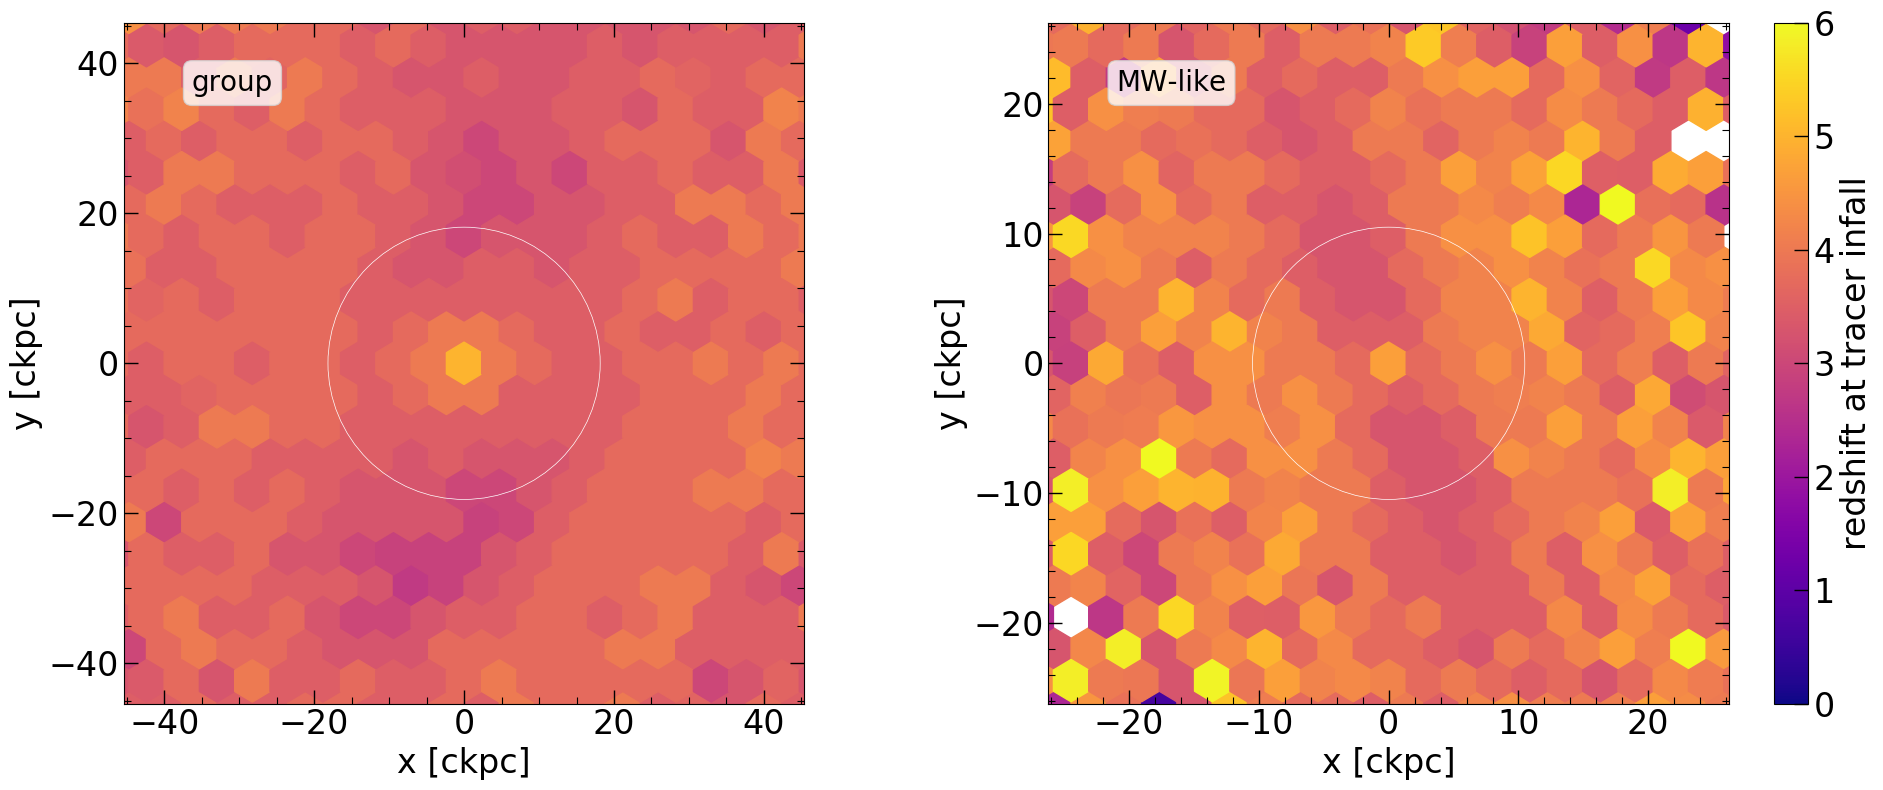

In [18]:
basePath='/virgotng/universe/IllustrisTNG/TNG50-1/output'

boxSize = il.groupcat.loadHeader(basePath,99)['BoxSize'] / h_const
num_shmr = 7
extra_inds = np.array([5,81,603])#89,646 or 85,626
# extra_inds = np.array([5,71,601])
sub_ids = np.array([167392, 454171, 632099])
print(sub_ids)
# sub_ids=np.array([28044,75514,108365])

type_names = np.array(['group','MW-like','dwarf'])
masks = [(0,0),(0,1),(1,0)]
masks = [0,1]

boxSize = il.groupcat.loadHeader(basePath, 99)['BoxSize']

fig, ax = plt.subplots(1,2,figsize=(20,8))
for i in range(2):
    f = h5py.File('files/' + basePath[32:39] +\
                  f'/mean_infall_times/mean_infall_times_all_subs_{num_shmr}shmr.hdf5','r')
    star_pos_insitu = f[f'special_subs/sub_extra_ind_{extra_inds[i]}_tracer_pos'][:,:]
    time_means = f[f'special_subs/sub_extra_ind_{extra_inds[i]}_time_means'][:]
    profiles = f['mean_infall_time_profiles'][extra_inds,:]
    dist_bins = f['distance_bins'][:]
    f.close()
    
    print('sub_id: ',sub_ids[i])
    print('star_pos_insitu: ',star_pos_insitu[0,:])
    sub = il.groupcat.loadSingle(basePath, 99, subhaloID = sub_ids[i])
    
    sub_pos = sub['SubhaloPos'] / h_const
    sub_hmr = sub['SubhaloHalfmassRadType'][4] / h_const

    pos = star_pos_insitu[:,:] - sub_pos[:]
    pos[np.where(pos > boxSize)] -= boxSize
    pos[np.where(pos < -boxSize)] += boxSize
    x = pos[:,0]
    y = pos[:,1]
    z = pos[:,2]
    print('subhalo_pos: ',sub_pos)
    print('pos: ',pos[0,:])
    
    mask = np.where(np.logical_and(abs(x)<7*sub_hmr,abs(y)<7*sub_hmr))[0]
    
#     ax[1,1].plot(dist_bins,profiles[i],label = type_names[i])
#     ax[1,1].fill_between(dist_bins,y16,y84,alpha = 0.3)
    
    #with mpl.rc_context({'figure.figsize' : (4.5,4.5)}):
    circle = plt.Circle((0,0),2*sub_hmr,color = 'white',fill=False,linewidth=0.5)
    ax[masks[i]].add_patch(circle)
    im = ax[masks[i]].hexbin(x[mask],y[mask],time_means[mask], reduce_C_function = np.nanmedian, \
                             cmap = 'plasma',vmin = 0, vmax = 6, gridsize = 27)
    ax[masks[i]].set_xlabel('x [ckpc]')
    ax[masks[i]].set_ylabel('y [ckpc]')
    ax[masks[i]].set_aspect('equal')
    ax[masks[i]].set_xlim(-5*sub_hmr,5*sub_hmr)
    ax[masks[i]].set_ylim(-5*sub_hmr,5*sub_hmr)
    ax[masks[i]].text(0.1,0.9,type_names[i], bbox=\
             dict(boxstyle="round",ec='lightgray',fc='white',alpha = 0.8),transform=ax[masks[i]].transAxes,size = 20)
    
cb = fig.colorbar(im,label = 'redshift at tracer infall')#, ax = ax[masks[-1]], orientation = 'vertical')
cb.minorticks_off()

# ax[1,1].set_aspect('equal')
# ax[1,1].legend()
# ax[1,1].set_xlabel(r'r [$\rm{R}_{0.5, \ast}$]')
# ax[1,1].set_ylabel(r'$z_{\rm{infall}}$')
# ax[1,1].set_ylim(1,6)
plt.tight_layout()
#plt.savefig('pics/mean_infall_times/image_mean_infall_time_group+MW.pdf', format = 'pdf')

### analysis for IGM and satellite tracers

(3260432,)
[      0       1       2 ... 3260409 3260410 3260414]
(1210247,)
(848759,)
[     0     16     24 ... 848723 848740 848747]
(67959,)
(31303,)
[    0    79   137 ... 31178 31196 31212]
(1221,)


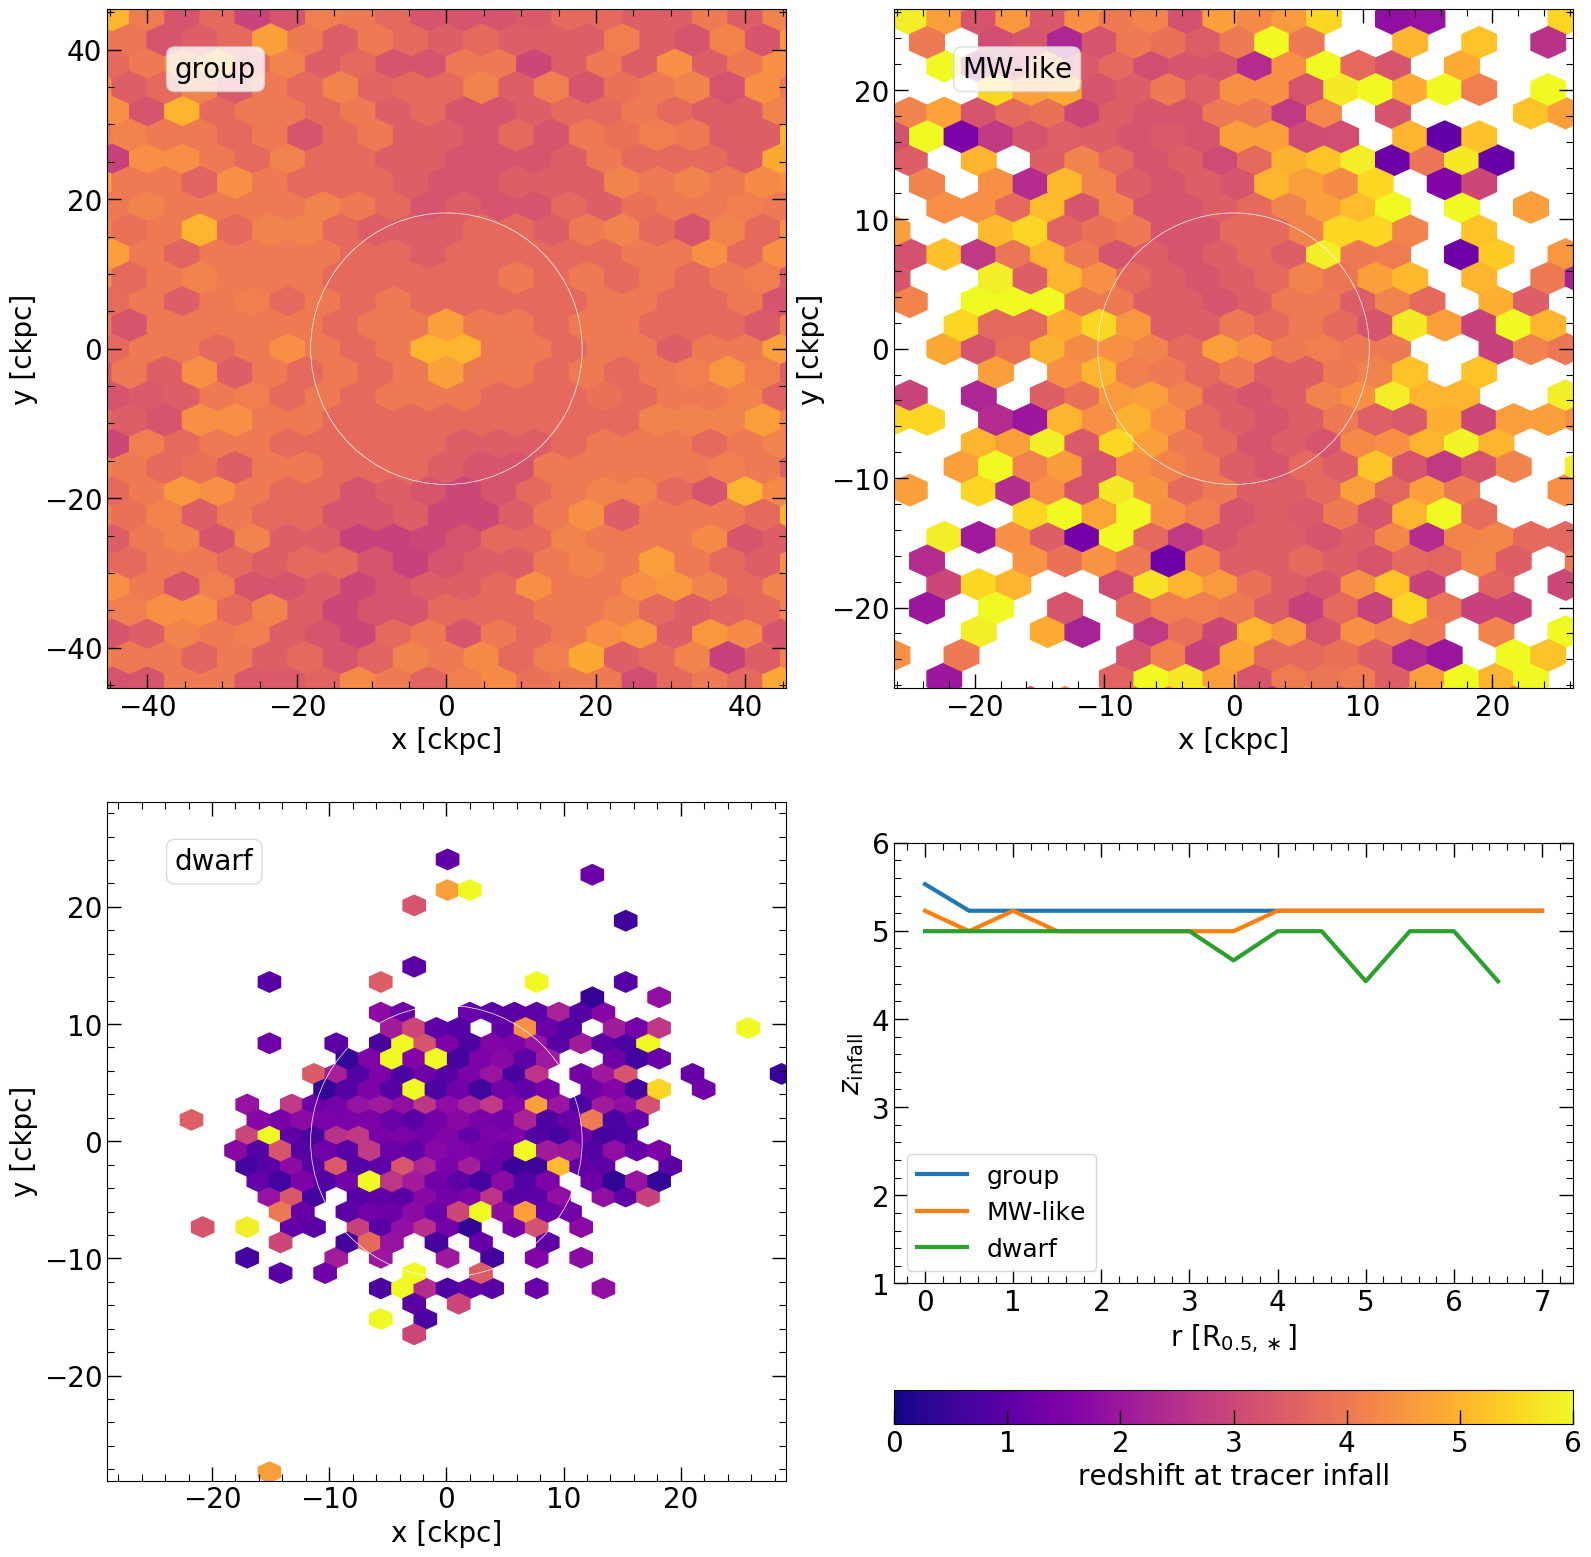

In [25]:
basePath='/virgotng/universe/IllustrisTNG/TNG50-1/output'

boxSize = il.groupcat.loadHeader(basePath,99)['BoxSize'] / h_const
num_shmr = 7
cut_snap = 21
extra_inds = np.array([5,81,603])
# extra_inds = np.array([5,71,601])
sub_ids = np.array([167392, 454171, 632099])
# sub_ids=np.array([28044,75514,108365])

type_names = np.array(['group','MW-like','dwarf'])
masks = [(0,0),(0,1),(1,0)]

boxSize = il.groupcat.loadHeader(basePath, 99)['BoxSize']

ptype = 2# 0 for regular, 1 for IGM tracers, 2 for satellite tracers
fig, ax = plt.subplots(2,2,figsize=(16,16))
for i in range(3):
    f = h5py.File('files/' + basePath[32:39] +\
                  f'/mean_infall_times/mean_infall_times_all_subs_{num_shmr}shmr_cut{cut_snap}.hdf5','r')
    star_pos_insitu = f[f'special_sub_{extra_inds[i]}/tracer_pos'][:,:]
    time_means = f[f'special_sub_{extra_inds[i]}/time_means'][:]
    igm_tracers = f[f'special_sub_{extra_inds[i]}/which_tracers_in_igm_at_cut'][:]
    satellite_tracers = f[f'special_sub_{extra_inds[i]}/which_tracers_in_satellites_at_cut'][:]
    profile = f['mean_infall_time_profiles'][extra_inds[i],ptype,:]
    dist_bins = f['distance_bins'][:]
    f.close()
    
    if ptype == 1 and igm_tracers.size <=1:
        print(f'No IGM tracers at snapshot 21 for sub with extra_ind {extra_inds[i]}!')
        continue
    elif ptype == 2 and satellite_tracers.size <= 1:
        print(f'No satellite tracers at snapshot 21 for sub with extra_ind {extra_inds[i]}!')
        continue
        
    if ptype == 1:
        print(time_means.shape)
        print(igm_tracers)
        print(igm_tracers.shape)
        star_pos_insitu = star_pos_insitu[igm_tracers,:]
        time_means = time_means[igm_tracers]
    elif ptype == 2:
        print(time_means.shape)
        print(satellite_tracers)
        print(satellite_tracers.shape)
        star_pos_insitu = star_pos_insitu[satellite_tracers,:]
        time_means = time_means[satellite_tracers]
    
#     print('sub_id: ',sub_ids[i])
#     print('star_pos_insitu: ',star_pos_insitu[0,:])
    sub = il.groupcat.loadSingle(basePath, 99, subhaloID = sub_ids[i])
    
    sub_pos = sub['SubhaloPos'] / h_const
    sub_hmr = sub['SubhaloHalfmassRadType'][4] / h_const

    pos = star_pos_insitu[:,:] - sub_pos[:]
    pos[np.where(pos > boxSize)] -= boxSize
    pos[np.where(pos < -boxSize)] += boxSize
    x = pos[:,0]
    y = pos[:,1]
#     print('subhalo_pos: ',sub_pos)
#     print('pos: ',pos[0,:])
    
    mask = np.where(np.logical_and(abs(x)<7*sub_hmr,abs(y)<7*sub_hmr))[0]
    
    ax[1,1].plot(dist_bins,profile,label = type_names[i])
#     ax[1,1].fill_between(dist_bins,y16,y84,alpha = 0.3)
    
    #with mpl.rc_context({'figure.figsize' : (4.5,4.5)}):
    circle = plt.Circle((0,0),2*sub_hmr,color = 'white',fill=False,linewidth=0.5)
    ax[masks[i]].add_patch(circle)
    im = ax[masks[i]].hexbin(x[mask],y[mask],time_means[mask], reduce_C_function = np.nanmedian, \
                             cmap = 'plasma',vmin = 0, vmax = 6, gridsize = (27,20))
    ax[masks[i]].set_xlabel('x [ckpc]')
    ax[masks[i]].set_ylabel('y [ckpc]')
    ax[masks[i]].set_aspect('equal')
    ax[masks[i]].set_xlim(-5*sub_hmr,5*sub_hmr)
    ax[masks[i]].set_ylim(-5*sub_hmr,5*sub_hmr)
    ax[masks[i]].text(0.1,0.9,type_names[i], bbox=\
             dict(boxstyle="round",ec='lightgray',fc='white',alpha = 0.8),transform=ax[masks[i]].transAxes,size = 20)
    
cb = fig.colorbar(im,label = 'redshift at tracer infall', ax = ax[1,1], orientation = 'horizontal')
cb.minorticks_off()

ax[1,1].set_aspect('equal')
ax[1,1].legend()
ax[1,1].set_xlabel(r'r [$\rm{R}_{0.5, \ast}$]')
ax[1,1].set_ylabel(r'$z_{\rm{infall}}$')
ax[1,1].set_ylim(1,6)
plt.tight_layout()
#plt.savefig('pics/mean_infall_times/image_mean_infall_time_50-1.pdf', format = 'pdf')

In [5]:
basePath='/virgotng/universe/IllustrisTNG/TNG50-1/output'
num_shmr = 7
cut_snap = 21
f = h5py.File('files/' + basePath[32:39] +\
              f'/mean_infall_times/mean_infall_times_all_subs_{num_shmr}shmr_cut{cut_snap}.hdf5','r')
dist_bins = f['distance_bins'][:]
profiles = f['mean_infall_time_profiles'][:,0,:]
medians = f['mean_infall_times_medians'][:,:]
f.close()

In [6]:
start_snap = 99

h_const=il.groupcat.loadHeader(basePath,99)['HubbleParam']

#introduce mass bins:
groups = il.groupcat.loadHalos(basePath, start_snap, fields = ['Group_M_Crit200','GroupFirstSub'])
group_masses = groups['Group_M_Crit200']*1e10/h_const

#differentiate between halos of dwarf / milky way / group size
dwarf_ids = np.where(np.logical_and(group_masses > 10**(10.8), group_masses < 10**(11.2)))[0]
mw_ids = np.where(np.logical_and(group_masses > 10**(11.8), group_masses < 10**(12.2)))[0]
group_ids = np.where(np.logical_and(group_masses > 10**(12.6), group_masses < 10**(13.4)))[0]
extra_small_dwarf_ids = np.where(np.logical_and(group_masses > 0, group_masses < 10**(10.8)))[0]
all_ids = np.arange(group_masses.shape[0])

#find ids of associated centrals
sub_ids_dwarfs = groups['GroupFirstSub'][dwarf_ids]
sub_ids_mw = groups['GroupFirstSub'][mw_ids]
sub_ids_groups = groups['GroupFirstSub'][group_ids]
sub_ids_extra_small_dwarfs = groups['GroupFirstSub'][extra_small_dwarf_ids]
all_central_ids = groups['GroupFirstSub'][:]

f = h5py.File(f'/vera/ptmp/gc/olwitt/TNG50-{basePath[38]}' +\
              f'/cumulative_radial_profile/igm_sat/rad_prof_tracer_frac_(200.0,15)_cut21_{start_snap}.hdf5','r')
extrapolated_sub_ids = f['which_central_galaxy_ids'][:]
f.close()
ex_ex = extrapolated_sub_ids[np.where(extrapolated_sub_ids != -1)]
dwarfs = tF.getIndices(tF.getIndices(sub_ids_dwarfs, all_central_ids), ex_ex)
mws = tF.getIndices(tF.getIndices(sub_ids_mw, all_central_ids), ex_ex)
groups = tF.getIndices(tF.getIndices(sub_ids_groups, all_central_ids), ex_ex)
extra_small_dwarfs = tF.getIndices(tF.getIndices(sub_ids_extra_small_dwarfs, all_central_ids), ex_ex)

In [7]:
haloIDs = np.take(np.arange(all_central_ids.shape[0])[np.where(all_central_ids != -1)],ex_ex)
print(haloIDs.shape)
halo_masses = np.log10(group_masses[haloIDs])

(42117,)


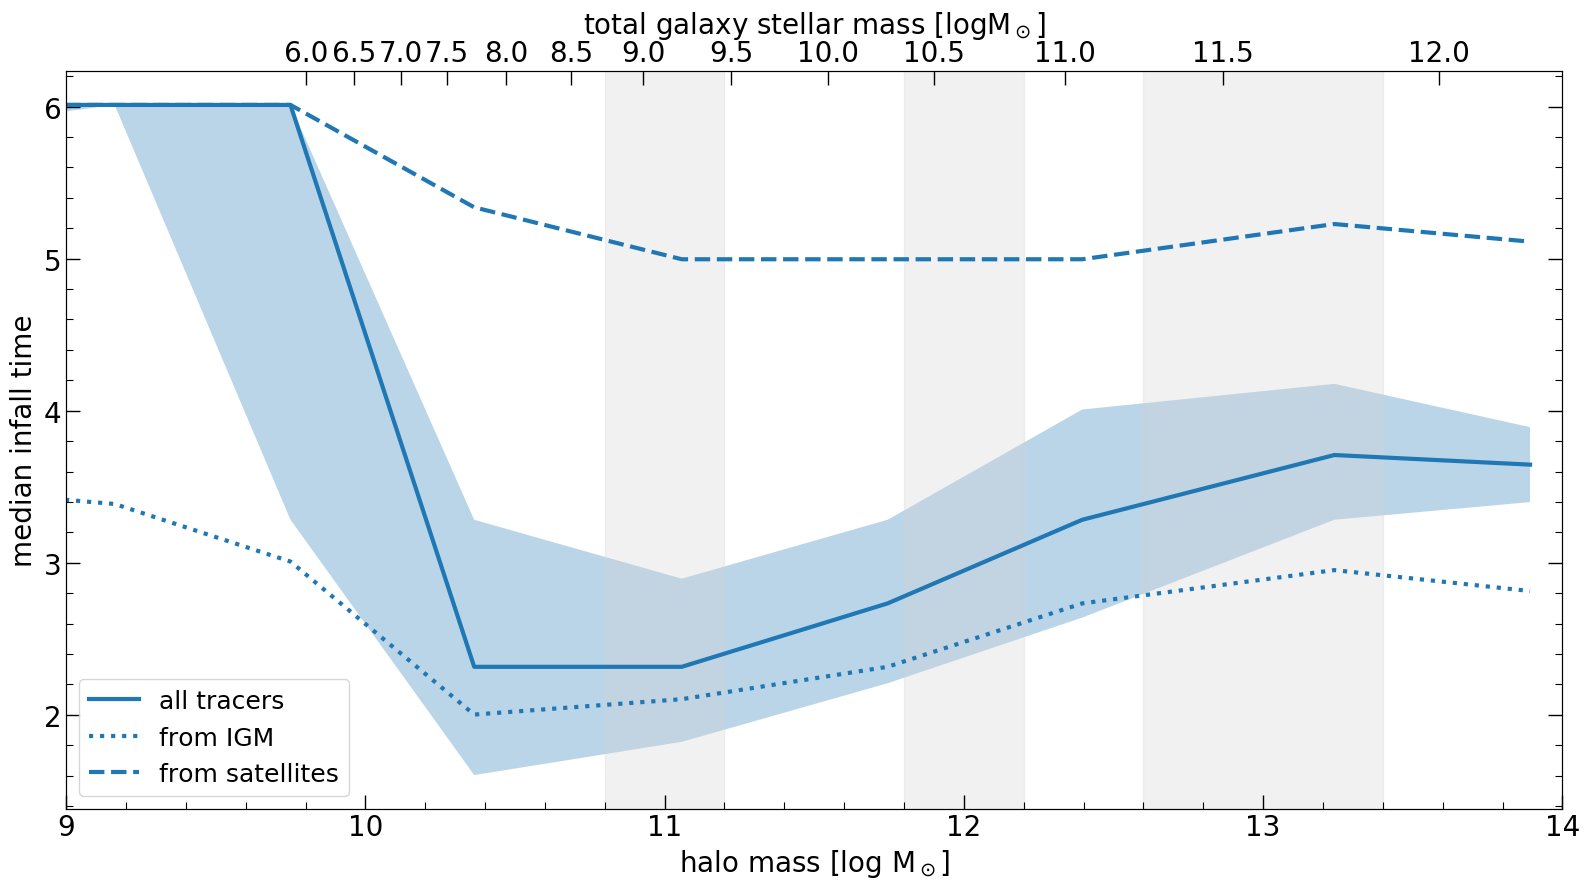

In [30]:
fig, ax = plt.subplots()

x, y, y16, y84 = funcs.binData_med(halo_masses, medians[:,0], 11)
plt.plot(x, y, color = 'tab:blue', linestyle = 'solid', label = 'all tracers')
plt.fill_between(x,y16,y84, alpha = 0.3)

x_igm, y_igm, y16_igm, y84_igm = funcs.binData_med(halo_masses, medians[:,1], 11)
plt.plot(x_igm, y_igm, color = 'tab:blue', linestyle = 'dotted', label = 'from IGM')

x_sat, y_sat, y16_sat, y84_sat = funcs.binData_med(halo_masses, medians[:,2], 11)
plt.plot(x_sat, y_sat, color = 'tab:blue', linestyle = 'dashed', label = 'from satellites')

plt.legend()
plt.xlabel(r'halo mass [log $\rm{M}_\odot$]')
plt.ylabel('median infall time')
plt.xlim(9,14)

rec_dwarf = Rectangle((10.8,-0.2),0.4,19, color = 'lightgray', alpha = 0.3)
ax.add_patch(rec_dwarf)
rec_mw = Rectangle((11.8,-0.2),0.4,19, color = 'lightgray', alpha = 0.3)
ax.add_patch(rec_mw)
rec_group = Rectangle((12.6,-0.2),0.8,19, color = 'lightgray', alpha = 0.3)
ax.add_patch(rec_group)

group_m = np.array([6.86093282699585, 7.398449420928955, 7.901801109313965, 8.393900871276855, 8.886045455932617,\
                    9.339580535888672, 9.809768676757812, 10.323699951171875, 10.840004920959473, 11.344971656799316,\
                    11.868677139282227, 12.379907608032227, 12.879098892211914, 13.441740036010742, 13.891986846923828])
gal_m = np.array([4.742977619171143, 4.718081474304199, 4.761687278747559, 4.795966625213623, 4.861518859863281,\
                  5.147671699523926, 6.013262748718262, 7.66148042678833, 8.850899696350098, 9.708621978759766,\
                  10.465829849243164, 11.046808242797852, 11.511899948120117, 11.899462699890137, 12.20790958404541])
secax = ax.twiny()
from scipy import interpolate
f_interp = interpolate.interp1d(gal_m, group_m)
new_tick_locations = np.array([6., 6.5, 7., 7.5, 8., 8.5, 9., 9.5, 10., 10.5, 11., 11.5,12.])
secax.set_xlim(ax.get_xlim())
secax.set_xticks(f_interp(new_tick_locations))
secax.set_xticklabels(new_tick_locations)
secax.minorticks_off()
secax.set_xlabel(r'total galaxy stellar mass [log$\rm{M}_\odot$]')
ax.minorticks_on()

plt.tight_layout()
plt.savefig('pics/mean_infall_times/infall_time_vs_halo_mass_50-1.pdf',format = 'pdf')

In [6]:
print(max(extra_small_dwarfs))
print(extrapolated_sub_ids.shape[0])
print(medians.shape[0])
print(np.where(extrapolated_sub_ids != -1)[0].shape[0])

15453
15454
15454
15454


In [14]:
print(dwarfs[int(dwarfs.size/2)])
print(mws[int(mws.size/2)])
print(groups[int(groups.size/2)])

print(dwarfs[0])
print(mws[0])
print(groups[0])

1700
217
28
601
71
5


In [11]:
print(dwarfs[int(dwarfs.size/2)])
print(mws[int(mws.size/2)])
print(groups[int(groups.size/2)])

print(dwarfs[0])
print(mws[0])
print(groups[0])

1667
221
28
603
81
5


In [95]:
print(profiles[1])

[5.22758097 4.42803374 4.42803374 4.17683491 4.17683491 4.00794511
 4.00794511 4.00794511 4.00794511 3.70877426 3.70877426 3.70877426
 3.49086137 3.49086137 3.49086137]


In [15]:
sub_ids = np.array([62321,92224,128802])
sub_ids = all_central_ids[np.where(all_central_ids!=-1)]
# the_profile = profiles[np.where(sub_ids[extrapolated_sub_ids] == 362994)[0][0],:]
extra_ind_group = np.where(sub_ids[extrapolated_sub_ids] == 28044)[0][0]
extra_ind_mw = np.where(sub_ids[extrapolated_sub_ids] == 92224)[0][0]
extra_ind_dwarf = np.where(sub_ids[extrapolated_sub_ids] == 128802)[0][0]

print(extra_ind_group, extra_ind_mw, extra_ind_dwarf)
print(sub_ids[extrapolated_sub_ids[extra_ind_dwarf]])
plt.plot(dist_bins, profiles[32])
plt.plot(dist_bins, profiles[204])
plt.plot(dist_bins, profiles[2078])

5 211 2227


NameError: name 'extra_ind' is not defined

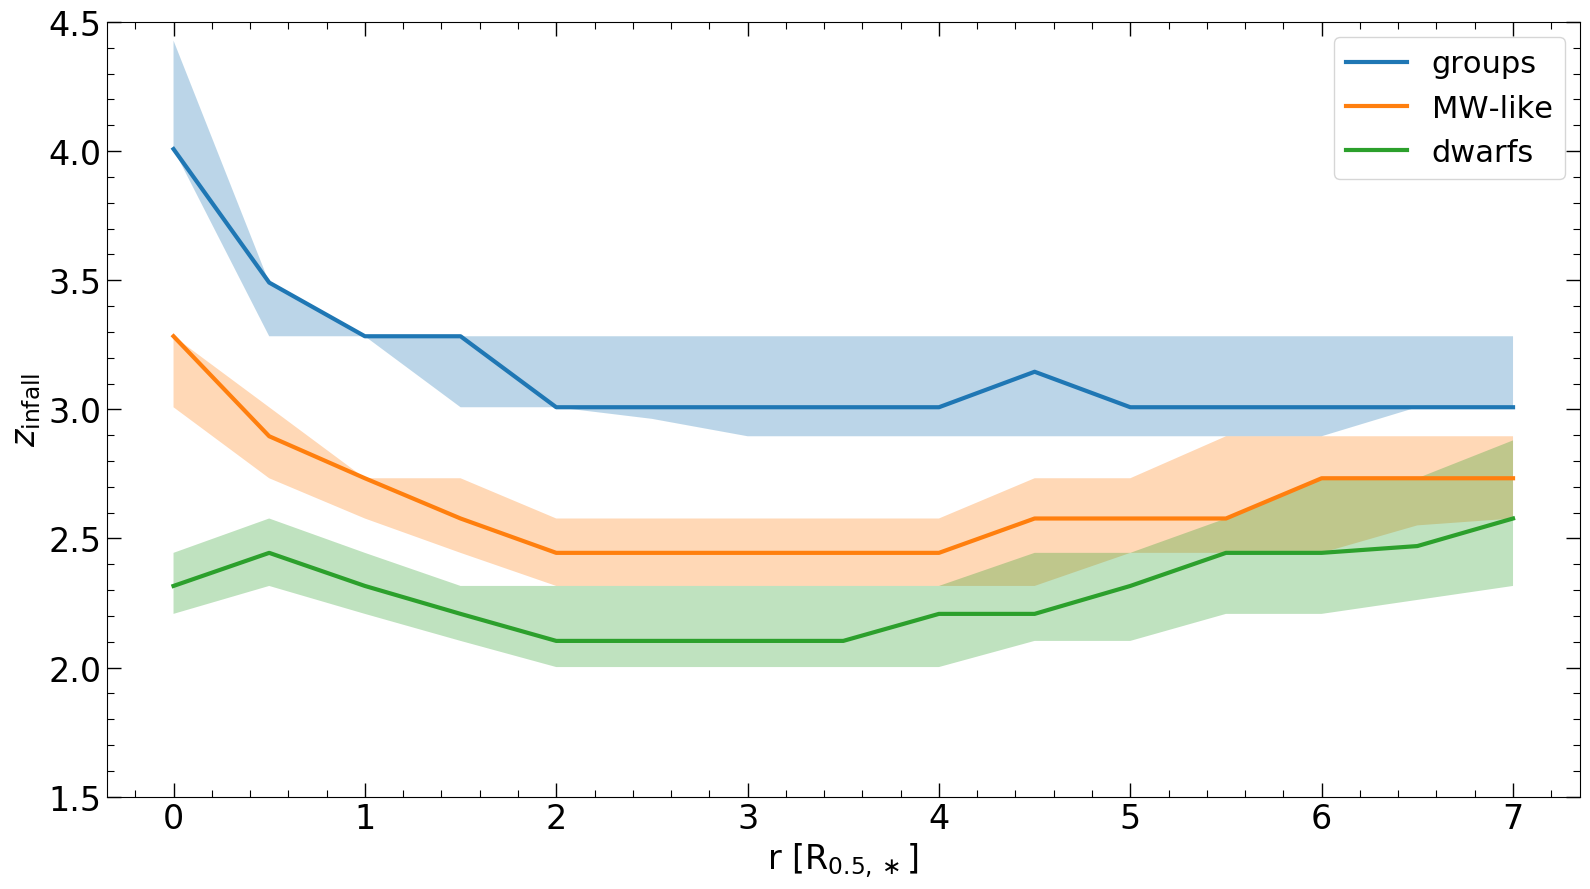

In [9]:
plt.plot(dist_bins,np.nanmedian(profiles[groups,:],axis=0), label = 'groups')
plt.fill_between(dist_bins,np.nanpercentile(profiles[groups,:],40,axis=0),\
                 np.nanpercentile(profiles[groups,:],60,axis=0),alpha = 0.3)

plt.plot(dist_bins,np.nanmedian(profiles[mws,:],axis=0), label = 'MW-like')
plt.fill_between(dist_bins,np.nanpercentile(profiles[mws,:],40,axis=0),\
                 np.nanpercentile(profiles[mws,:],60,axis=0),alpha = 0.3)

plt.plot(dist_bins,np.nanmedian(profiles[dwarfs,:],axis=0), label = 'dwarfs')
plt.fill_between(dist_bins,np.nanpercentile(profiles[dwarfs,:],40,axis=0),\
                 np.nanpercentile(profiles[dwarfs,:],60,axis=0),alpha = 0.3)

# plt.plot(dist_bins,np.nanmedian(profiles[extra_small_dwarfs,:],axis=0), label = 'extra-small dwarfs')
# plt.fill_between(dist_bins,np.nanpercentile(profiles[extra_small_dwarfs,:],40,axis=0),\
#                  np.nanpercentile(profiles[extra_small_dwarfs,:],60,axis=0),alpha = 0.3)

# plt.plot(dist_bins,np.nanmedian(profiles,axis=0), label = 'all galaxies')
# plt.fill_between(dist_bins,np.nanpercentile(profiles,40,axis=0),\
#                  np.nanpercentile(profiles,60,axis=0),alpha = 0.3)

plt.legend()
plt.xlabel(r'r [$\rm{R}_{0.5, \ast}$]')
plt.ylabel(r'$z_{\rm{infall}}$')
plt.ylim(1.5,4.5)
plt.tight_layout()
#plt.savefig('pics/mean_infall_times/mean_infall_times_notall.pdf',format='pdf')

In [56]:
def one_gal_profile_vs_redshift(basePath, start_snap, central_id = 0, max_dist = 1.5):
    from os.path import isfile
    
    onlyGas = False
    start = time.time()
    header = il.groupcat.loadHeader(basePath,start_snap)
    boxSize = header['BoxSize']
    
    file = 'files/'+basePath[32:39]+'/all_parent_indices.hdf5'
    if isfile(file):
        f = h5py.File(file,'r')
    else:
        f = h5py.File('/vera/ptmp/gc/olwitt/'+basePath[32:39]+f'/parent_indices_{start_snap}.hdf5','r')
    numTracersInParents = f[f'snap_0{start_snap}/numTracersInParents'][:]
    f.close()
    snaps = np.arange(start_snap,12,-1) #until z=6 is sufficient
    
    sub_positions = h5py.File('files/' + basePath[32:39] + '/SubhaloPosAtAllSnaps_extrapolated.hdf5','r') 
    sub_pos = sub_positions['SubhaloPos'][central_id,:,:]
    is_extrapolated = sub_positions['is_extrapolated'][central_id]
    assert is_extrapolated, 'choose a halo with extrapolated subhalo position history'
    sub_positions.close()
    
    groupFirstSub = il.groupcat.loadHalos(basePath,start_snap,fields = ['GroupFirstSub'])
    haloID = np.where(groupFirstSub == central_id)[0]
    assert haloID.size == 1, 'use subhalo that is a central galaxy'
    print('haloID: ',haloID[0])
    r_vir = il.sublink.loadTree(basePath, start_snap, id = central_id, fields = 'Group_R_Crit200', onlyMPB = True)
    
    end_load = time.time()
    print('time for loading: ',end_load-start)
    
    insituStarsInSubOffset = tF.insituStarsInSubOffset(basePath,start_snap)
    #there might be more tracers -> parents in one galaxy at higher redshifts than insitu stars at redshift 0
    parentsInSubOffset = tF.tracersInSubhalo(insituStarsInSubOffset,numTracersInParents).astype(int)
    parentsInSubOffset = np.insert(parentsInSubOffset,0,0)
    
    end_offsets = time.time()
    print('time for offsets: ',end_offsets-end_load)
    
    num_bins = 100
    bins = np.linspace(0,max_dist,num_bins)
    num = np.zeros((snaps.size,num_bins))
    
    for i in range(snaps.size):
    #for i in range(1):
        file = 'files/' + basePath[32:39] + '/all_parent_indices.hdf5'
        if isfile(file):
            all_parent_indices = h5py.File(file,'r')
        else:
            all_parent_indices = h5py.File('/vera/ptmp/gc/olwitt/' + basePath[32:39] +\
                                           f'/parent_indices_{snaps[i]}.hdf5','r')
        parent_indices = all_parent_indices[f'snap_' + str(snaps[i]).zfill(3) + '/parent_indices'][:,:]
        all_parent_indices.close()
        
        indices_of_sub = np.arange(parentsInSubOffset[central_id],parentsInSubOffset[central_id+1])
        parent_indices_of_sub = parent_indices[indices_of_sub,:].astype(int)
        
        all_gas_pos = il.snapshot.loadSubset(basePath, snaps[i], 'gas', fields = ['Coordinates'])
        all_star_pos = il.snapshot.loadSubset(basePath, snaps[i], 'stars', fields = ['Coordinates'])
        
        particle_pos = np.zeros((indices_of_sub.shape[0],3))
        gas_mask = np.where(parent_indices_of_sub[:,1] == 0)[0]
        star_mask = np.where(parent_indices_of_sub[:,1] == 1)[0]
        
        gas_parent_indices = parent_indices_of_sub[gas_mask,0].astype(int)
        particle_pos[gas_mask,:] = all_gas_pos[gas_parent_indices,:]

        star_parent_indices = parent_indices_of_sub[star_mask,0].astype(int)
        particle_pos[star_mask,:] = all_star_pos[star_parent_indices,:]
        
        
        gas_parent_indices = parent_indices[np.where(parent_indices[:,1] == 0)[0],0]
        gas_pos = all_gas_pos[gas_parent_indices.astype(int)]

        star_parent_indices = parent_indices[np.where(parent_indices[:,1] == 1)[0],0]
        star_pos = all_star_pos[star_parent_indices.astype(int)]
        del all_gas_pos, all_star_pos
        if i==0:
            end_load2 = time.time()
            print('time for 2nd loading: ',end_load2-end_offsets)

        subhalo_position = sub_pos[99-snaps[i]]
        
        rad_dist = funcs.dist_vector_nb(subhalo_position,particle_pos,boxSize)
        
        if i==0:
            end_prof = time.time()
            print('time for computing profiles: ',end_prof-end_load2)
        
        num[i,:] = funcs.binData_w_bins(rad_dist,bins = bins * r_vir[i])
        num[i,:] = num[i,:]/sum(num[i,:]) #we're only interested in the fraction of tracers in that bin
        
        if i==0:
            end_bin = time.time()
            print('time for binning: ',end_bin-end_prof)
    
        print(snaps[i],' done;',end=' ',flush=True)
    return bins, num

In [57]:
%%time
basePath = '/virgotng/universe/IllustrisTNG/TNG50-2/output'
bins, num= one_gal_profile_vs_redshift(basePath,99, central_id = 28044, max_dist = 1.5)
# z = iF.give_z_array(basePath)
f = h5py.File('files/TNG50-2/rad_prof_z_tracer_frac_sub28044_1.5r_vir_new.hdf5','w')
f.create_dataset('bins',data = bins)
f.create_dataset('values',data = num)
f.close()

haloID:  5
time for loading:  5.407158613204956
time for offsets:  2.0434205532073975
time for 2nd loading:  74.27534794807434
time for computing profiles:  0.0061261653900146484
time for binning:  0.0359036922454834
99  done; 98  done; 97  done; 96  done; 95  done; 94  done; 93  done; 92  done; 91  done; 90  done; 89  done; 88  done; 87  done; 86  done; 85  done; 84  done; 83  done; 82  done; 81  done; 80  done; 79  done; 78  done; 77  done; 76  done; 75  done; 74  done; 73  done; 72  done; 71  done; 70  done; 69  done; 68  done; 67  done; 66  done; 65  done; 64  done; 63  done; 62  done; 61  done; 60  done; 59  done; 58  done; 57  done; 56  done; 55  done; 54  done; 53  done; 52  done; 51  done; 50  done; 49  done; 48  done; 46  done; 45  done; 44  done; 43  done; 42  done; 41  done; 40  done; 39  done; 38  done; 37  done; 36  done; 35  done; 34  done; 33  done; 32  done; 31  done; 30  done; 29  done; 28  done; 27  done; 26  done; 25  done; 24  done; 23  done; 22  done; 21  done; 20 

In [4]:
# f = h5py.File('files/TNG50-2/rad_prof_z_tracer_frac_sub28044_1.5r_vir_new.hdf5','w')
# f.create_dataset('bins',data = bins)
# f.create_dataset('values',data = num)
# f.close()

In [4]:
f = h5py.File('files/TNG50-2/rad_prof_z_tracer_frac_sub28044_1.5r_vir_new.hdf5','r')
bins = f['bins'][:]
num = f['values'][:,:]
z = iF.give_z_array(basePath)
f.close()

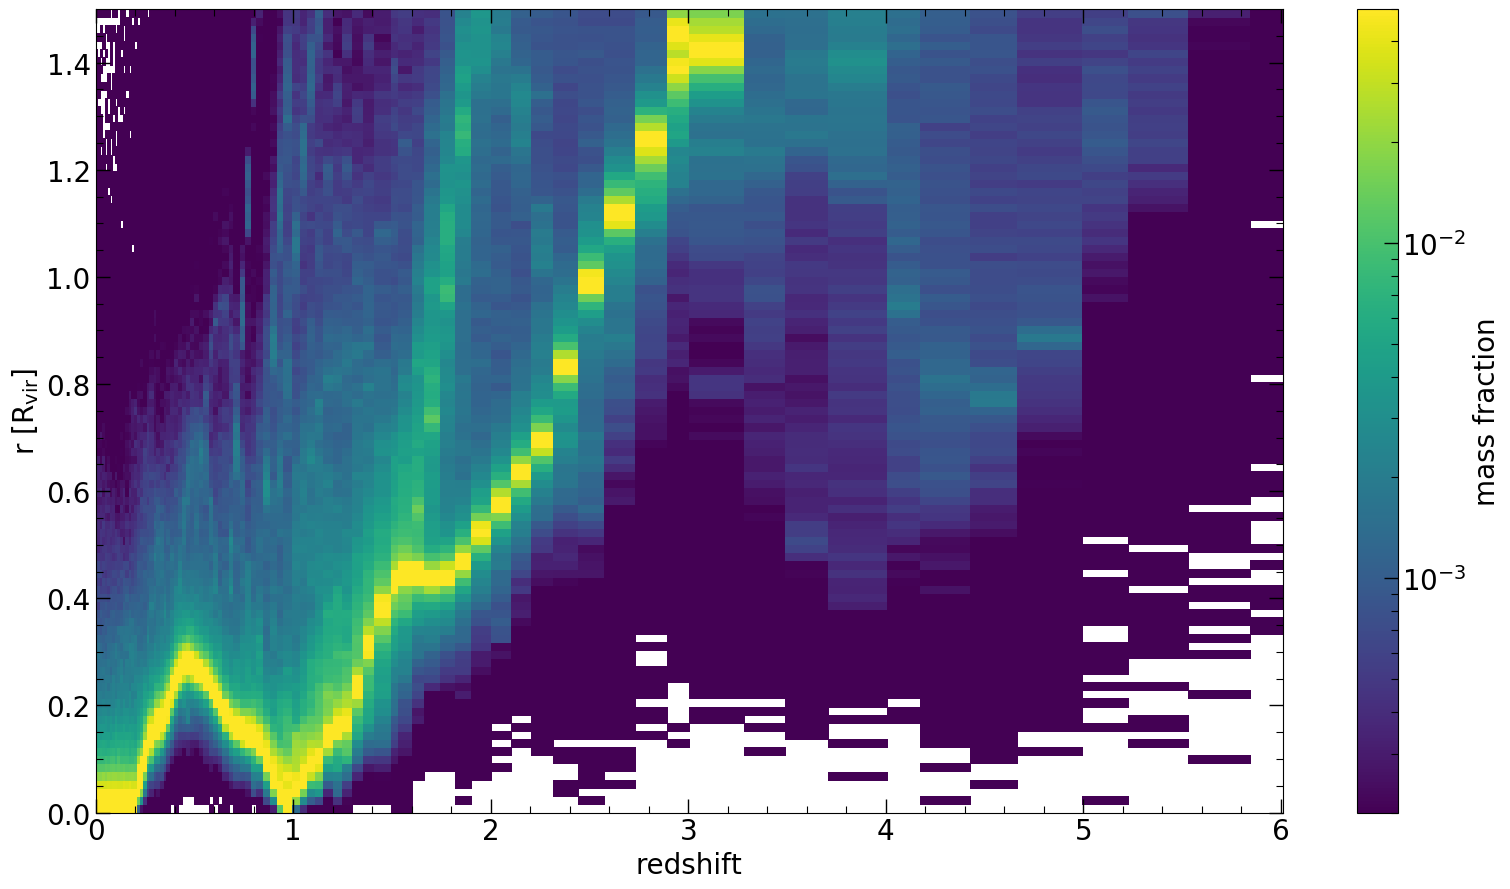

In [6]:
plt.pcolormesh(z[:87],bins,num[:,:].T,norm = mpl.colors.LogNorm(2e-4,5e-2), shading = 'auto',linewidth = 0,\
               rasterized = True)
#plt.imshow(np.rot90(num[:,:87]),norm = mpl.colors.LogNorm(1e-3,5e-1))
cb = plt.colorbar(label='mass fraction')
#cb.set_label(,size=18)
#cb.ax.tick_params(labelsize = 15)
plt.ylabel(r'r [$\rm{R}_{\rm{vir}}$]')
plt.xlabel('redshift')
plt.tight_layout()
#plt.savefig('pics/radial_profiles/rad_prof_z_tracer_frac_sub28044_1.5r_vir.pdf',format='pdf')

In [10]:
def one_gal_profile_from_radial_profile(basePath, extra_index, start_snap, end_snap, cut_snap, num_shmr, num_r_vir,\
                                        origin, what):
    snaps = np.arange(start_snap, end_snap,-1)
    n = snaps.size
    filename = '/vera/ptmp/gc/olwitt/' + basePath[32:39] +\
                      f'/cumulative_radial_profile/igm_sat/rad_prof_tracer_frac_({num_shmr},{num_r_vir})\
_cut{cut_snap}_99.hdf5'
    f = h5py.File(filename,'r')
    dist_bins = f[f'distance_bins_{what}'][:]
    f.close()
    
    profile_evo = np.empty((n,dist_bins.size))
    for i in range(n):
        filename = '/vera/ptmp/gc/olwitt/' + basePath[32:39] +\
                      f'/cumulative_radial_profile/igm_sat/rad_prof_tracer_frac_({num_shmr},{num_r_vir})\
_cut{cut_snap}_{snaps[i]}.hdf5'
        f = h5py.File(filename,'r')
        profiles = f[f'cumulative_profiles_{what}'][:,:,:]
        profile_evo[i] = profiles[extra_index,origin,:]
        print(f'snap {snaps[i]} done;',end=' ', flush = True)
    return dist_bins, profile_evo

In [4]:
basePath = '/virgotng/universe/IllustrisTNG/TNG50-1/output'
start_snap = 99

h_const=il.groupcat.loadHeader(basePath,99)['HubbleParam']

#introduce mass bins:
groups = il.groupcat.loadHalos(basePath, start_snap, fields = ['Group_M_Crit200','GroupFirstSub'])
group_masses = groups['Group_M_Crit200']*1e10/h_const

#differentiate between halos of dwarf / milky way / group size
dwarf_ids = np.where(np.logical_and(group_masses > 10**(10.8), group_masses < 10**(11.2)))[0]
mw_ids = np.where(np.logical_and(group_masses > 10**(11.8), group_masses < 10**(12.2)))[0]
group_ids = np.where(np.logical_and(group_masses > 10**(12.6), group_masses < 10**(13.4)))[0]
all_ids = np.arange(group_masses.shape[0])

#find ids of associated centrals
sub_ids_dwarves = groups['GroupFirstSub'][dwarf_ids]
sub_ids_mw = groups['GroupFirstSub'][mw_ids]
sub_ids_groups = groups['GroupFirstSub'][group_ids]
all_central_ids = groups['GroupFirstSub'][:]

print('mass loading complete.',flush=True)

mass loading complete.


In [7]:
basePath = '/virgotng/universe/IllustrisTNG/TNG50-1/output'
filename = '/vera/ptmp/gc/olwitt/' + basePath[32:39] +\
                      f'/cumulative_radial_profile/igm_sat/rad_prof_tracer_frac_(200.0,15)\
_cut21_99.hdf5'
f = h5py.File(filename,'r')
extrapolated_sub_ids = f['which_galaxy_ids'][:]
f.close()
sub_ids = all_central_ids[np.where(all_central_ids != -1)]
extra_ind_mw = np.where(sub_ids[extrapolated_sub_ids] == 167392)[0]
print(extra_ind_mw)

[5]


In [11]:
inds = tF.getIndices(tF.getIndices(sub_ids_groups, all_central_ids), extrapolated_sub_ids)
print(inds.shape[0])

40


In [13]:
print(sub_ids_dwarves.shape[0])
print(sub_ids_mw.shape[0])
print(sub_ids_groups.shape[0])

1315
173
40


subhalo ID:  167392
snap 99 done; snap 98 done; snap 97 done; snap 96 done; snap 95 done; snap 94 done; snap 93 done; snap 92 done; snap 91 done; snap 90 done; snap 89 done; snap 88 done; snap 87 done; snap 86 done; snap 85 done; snap 84 done; snap 83 done; snap 82 done; snap 81 done; snap 80 done; snap 79 done; snap 78 done; snap 77 done; snap 76 done; snap 75 done; snap 74 done; snap 73 done; snap 72 done; snap 71 done; snap 70 done; snap 69 done; snap 68 done; snap 67 done; snap 66 done; snap 65 done; snap 64 done; snap 63 done; snap 62 done; snap 61 done; snap 60 done; snap 59 done; snap 58 done; snap 57 done; snap 56 done; snap 55 done; snap 54 done; snap 53 done; snap 52 done; snap 51 done; snap 50 done; snap 49 done; snap 48 done; snap 47 done; snap 46 done; snap 45 done; snap 44 done; snap 43 done; snap 42 done; snap 41 done; snap 40 done; snap 39 done; snap 38 done; snap 37 done; snap 36 done; snap 35 done; snap 34 done; snap 33 done; snap 32 done; snap 31 done; snap 30 done; 

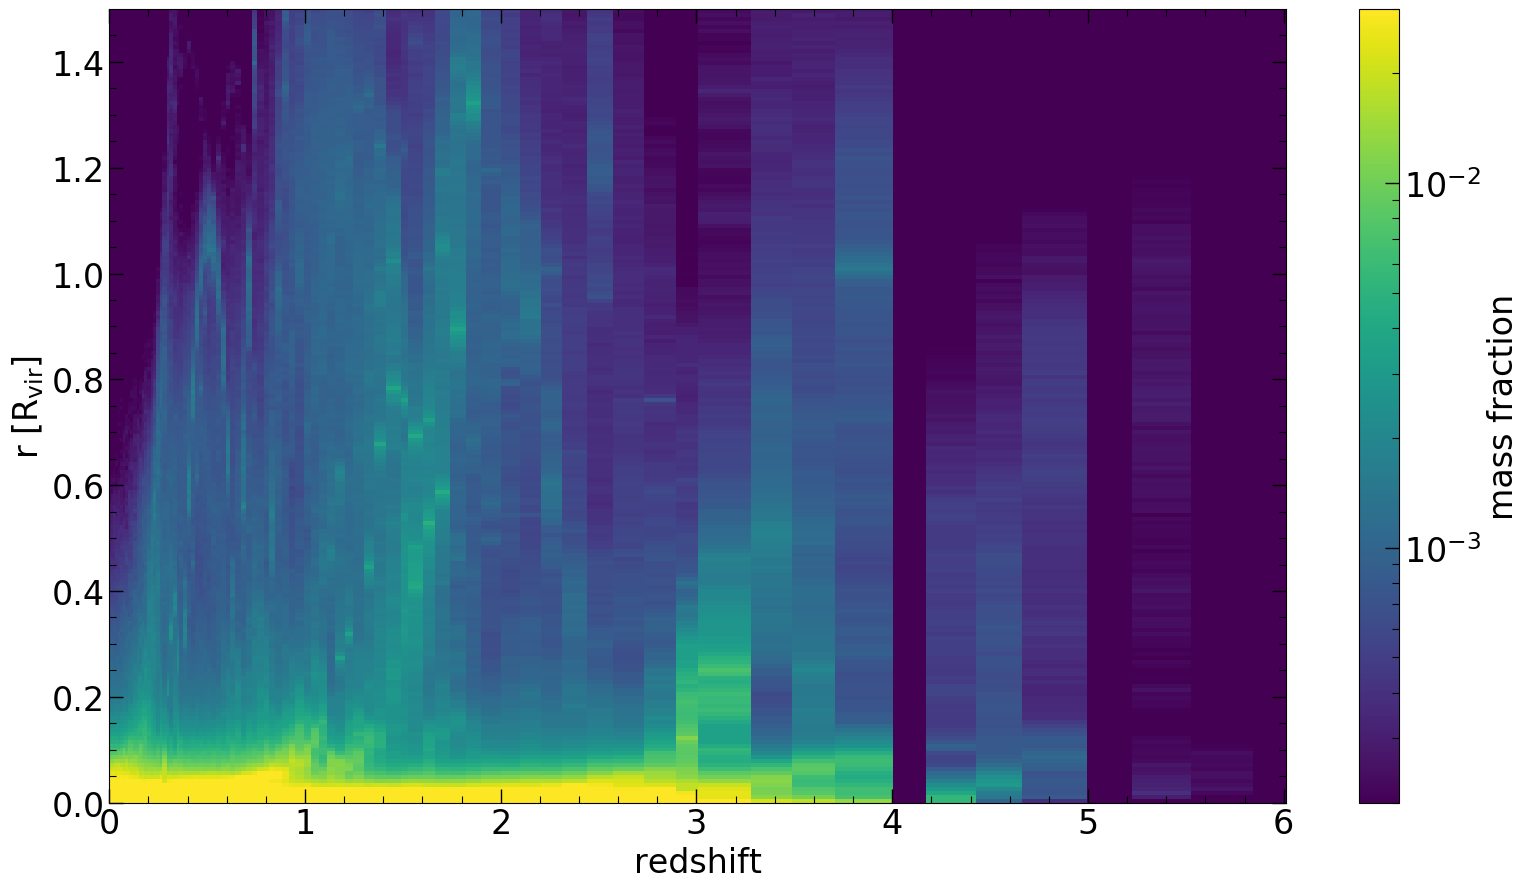

In [12]:
basePath = '/virgotng/universe/IllustrisTNG/TNG50-1/output'
start_snap = 99
index = 5#np.array([5,85,626]), sub_ids = np.array([167392, 454171, 632099]) or 1000

gtype = 'groups'
target_snap = 12

z = iF.give_z_array(basePath)
z = z[99-start_snap:99-target_snap]

cut_snap = 21
num_shmr = 20.0
num_r_vir = 1.5
origin = 0 #0 for regular, 1 for igm, 2 for satellites
what = 'r_vir' #r_vir or shmr possible

# if gtype == 'dwarves':
#     sub_ids = sub_ids_dwarves
# elif gtype == 'mw':
#     sub_ids = sub_ids_mw
# elif gtype == 'groups':
#     sub_ids = sub_ids_groups
# else:
#     sub_ids = all_central_ids

filename = '/vera/ptmp/gc/olwitt/' + basePath[32:39] +\
                      f'/cumulative_radial_profile/igm_sat/rad_prof_tracer_frac_({num_shmr},{num_r_vir})\
_cut{cut_snap}_99.hdf5'
f = h5py.File(filename,'r')
extrapolated_sub_ids = f['which_galaxy_ids'][:]
f.close()

# extra_index = tF.getIndices(tF.getIndices(sub_ids, all_central_ids), extrapolated_sub_ids)[index]
extra_index = index
print('subhalo ID: ', np.take(all_central_ids[np.where(all_central_ids != -1)],extrapolated_sub_ids[extra_index]))

bins, num = one_gal_profile_from_radial_profile(basePath, extra_index, start_snap, target_snap, cut_snap,\
                                                num_shmr, num_r_vir, origin, what)

diff = np.diff(num,axis=1,prepend=0)
diff[np.where(np.isnan(diff))] = 1e-5
diff[np.where(diff == 0)] = 1e-5

half = int(bins.size/2)
plt.pcolormesh(z,bins,diff.T,norm = mpl.colors.LogNorm(2e-4,3e-2), shading = 'auto',linewidth = 0,\
               rasterized = True)
#plt.imshow(np.rot90(num[:,:87]),norm = mpl.colors.LogNorm(1e-3,5e-1))
cb = plt.colorbar(label='mass fraction')
#cb.set_label(,size=18)
#cb.ax.tick_params(labelsize = 15)
plt.ylabel(r'r [$\rm{R}_{vir}$]')
plt.xlabel('redshift')
plt.tight_layout()
# plt.savefig('pics/tmp.jpg', format = 'jpg')

In [17]:
z = iF.give_z_array(basePath)
print(np.round(z[99-67],2))

0.5


In [7]:
diff = np.diff(num,axis=1,prepend=0)
diff[np.where(np.isnan(diff))] = 1e-5
diff[np.where(diff == 0)] = 1e-5

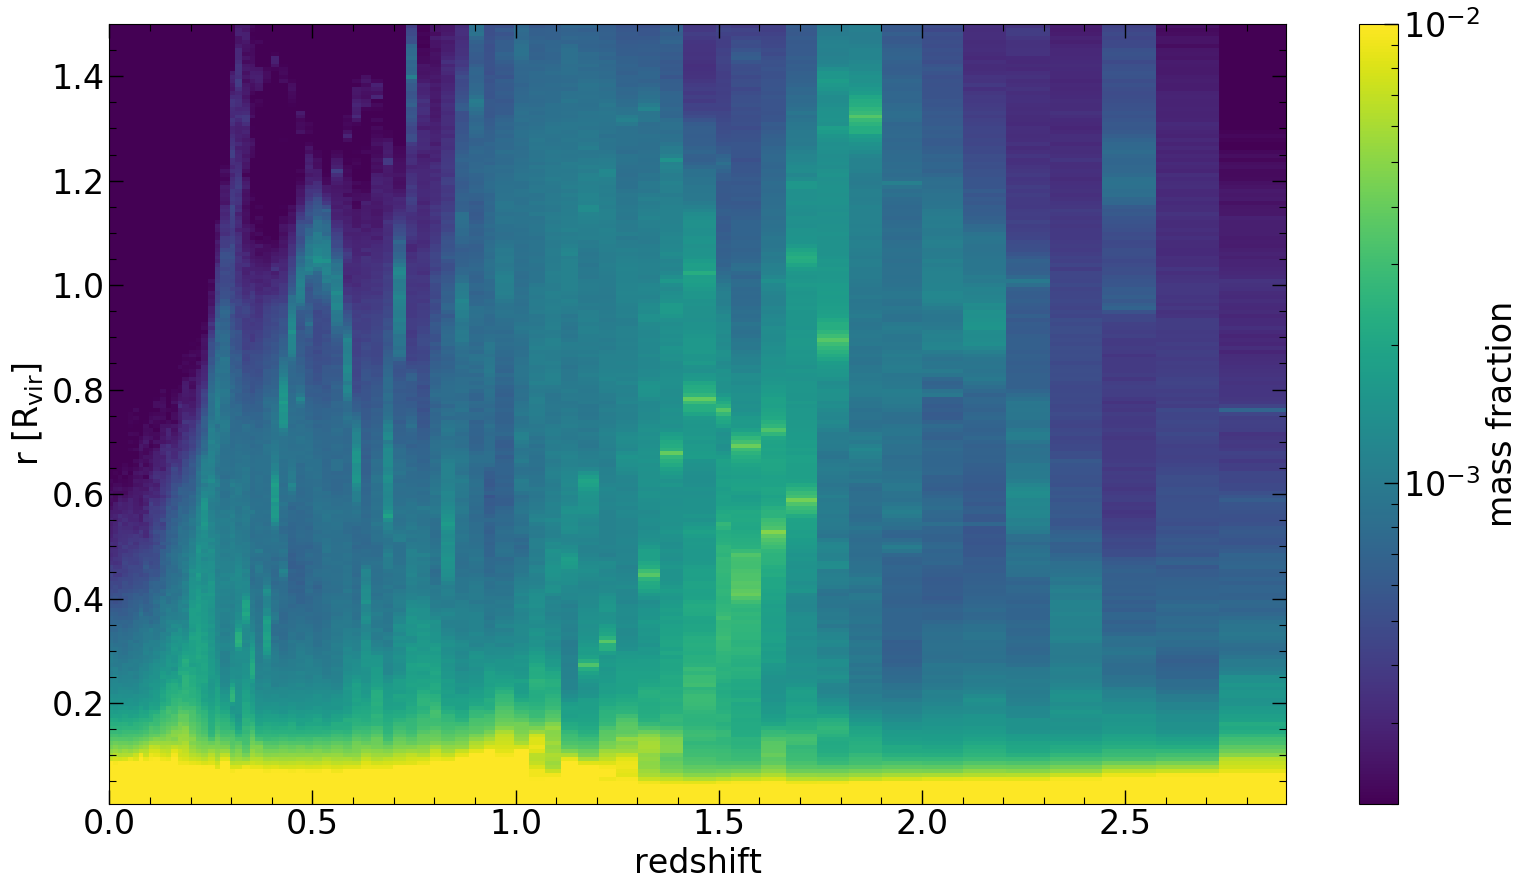

In [14]:
half = int(bins.size/2)
stop = 99 - 25
plt.pcolormesh(z[:stop],bins[1:],diff[:stop,1:].T,norm = mpl.colors.LogNorm(2e-4,1e-2), shading = 'auto',linewidth = 0,\
               rasterized = True)
#plt.imshow(np.rot90(num[:,:87]),norm = mpl.colors.LogNorm(1e-3,5e-1))
cb = plt.colorbar(label='mass fraction')
#cb.set_label(,size=18)
#cb.ax.tick_params(labelsize = 15)
plt.ylabel(r'r [$\rm{R}_{vir}$]')
plt.xlabel('redshift')
plt.tight_layout()
# plt.savefig('pics/tmp_50-2_sub28044.jpg', format = 'jpg')
#plt.savefig('pics/radial_profiles/rad_prof_tracer_frac_group_TNG50-1_1.5r_vir.pdf',format='pdf')

### tests to understand the problem:

In [20]:
r_vir = il.sublink.loadTree(basePath, 99, id = 167392, fields = ['Group_R_Crit200'], onlyMPB = True)/0.6774
print(r_vir)
print(r_vir[99-50])

[583.2861   586.7965   593.1458   597.07513  603.3925   607.83325
 614.5573   618.82074  625.97845  630.7267   636.77484  641.5912
 644.22003  648.7032   651.4019   654.70917  657.4902   658.72516
 659.3372   658.94183  656.7495   640.4394   637.6733   629.4505
 631.458    633.62103  637.36523  641.6224   646.1866   652.4465
 657.65375  664.5081   671.5142   677.89014  683.7805   689.0359
 690.07983  689.9575   688.9365   688.397    686.4594   676.5061
 653.03326  644.00085  640.22845  636.04425  626.55646  614.8903
 610.05566  604.6449   602.58563  600.3129   601.6788   603.56934
 611.2753   615.516    621.88885  626.30994  631.7403   628.8451
 625.5838   616.9634   608.03204  592.9207   566.40936  527.238
 525.75037  526.87775  518.44794  503.0812   490.9103   479.94333
 479.79156  466.57535  457.82367  364.01068  337.46857  324.8606
 295.0531   284.9852   259.45285  217.20267  186.33751  175.94724
 152.16136  139.67076  137.89119  130.70573  120.01422  113.392525
 100.34952   88.197

In [25]:
target_sub_id = il.sublink.loadTree(basePath, 99, id = 0, fields = ['SubfindID'], onlyMPB = True)
print(target_sub_id)
print(target_sub_id[99-80])

[    0     0     0     0     0     0     0     0     0     0     0     2
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0 15511 15404 15624 15693 15268 15472 15216
 15220 15195  9247  8857  8266 15343  8068 14355 13700 13673 13021  9440
 10323  8987  3769  3258  5996  4230  3857  3618  3738  2918  3119  1836
  4458  4301  4308  3400  2314  2120  2017  1470  1393  1317  1329  3971
  6134  4334  3853  1171]
0


In [47]:
tree = il.sublink.loadTree(basePath, 50, id = target_sub_id[99-50],\
                           fields = ['FirstProgenitorID', 'NextProgenitorID'], onlyMPB = True)
print(tree['FirstProgenitorID'])

[58337121 58337122 58337123 58337124 58337125 58337126 58337127 58337128
 58337129 58337130 58337131 58337132 58337133 58337134 58337135 58337136
 58337137 58337138 58337139 58337140 58337141 58337142 58337143 58337144
 58337145 58337146 58337147 58337148 58337149 58337150 58337151 58337152
 58337153 58337154 58337155 58337156 58337157 58337158 58337159 58337160
 58337161 58337162 58337163 58337164 58337165 58337166 58337167 58337168
 58337169 58337170       -1]


In [19]:
#z = iF.give_z_array(basePath)
print(z[99-80])

0.2613432561610123


In [44]:
snap = 79
f = h5py.File(basePath[:-6] + f'postprocessing/MergerHistory/MergerHistory_0{snap}.hdf5','r')
print(f.keys())
last_major_merger = f['SnapNumLastMajorMerger'][:]
print(last_major_merger[target_sub_id[99 - snap]])
f.close()

<KeysViewHDF5 ['AccretedStellarMassLast2Gyr', 'AccretedStellarMassLast5Gyr', 'AccretedStellarMassLast8Gyr', 'AccretedStellarMassSinceRedshift5', 'Header', 'MassLastMajorMerger', 'MeanGasFraction', 'MeanLookbackTime', 'MeanMassRatio', 'MeanRedshift', 'MeanRedshiftAtPeakMassLast2Gyr', 'MeanRedshiftAtPeakMassLast5Gyr', 'MeanRedshiftAtPeakMassLast8Gyr', 'MeanRedshiftAtPeakMassSinceRedshift5', 'MeanStellarMassLast2Gyr', 'MeanStellarMassLast5Gyr', 'MeanStellarMassLast8Gyr', 'MeanStellarMassRatioLast2Gyr', 'MeanStellarMassRatioLast5Gyr', 'MeanStellarMassRatioLast8Gyr', 'MeanStellarMassRatioSinceRedshift5', 'MeanStellarMassSinceRedshift5', 'NumMajorMergersLast250Myr', 'NumMajorMergersLast2Gyr', 'NumMajorMergersLast500Myr', 'NumMajorMergersLast5Gyr', 'NumMajorMergersLast8Gyr', 'NumMajorMergersLastGyr', 'NumMajorMergersSinceRedshift5', 'NumMajorMergersSinceRedshiftOne', 'NumMajorMergersSinceRedshiftTwo', 'NumMajorMergersTotal', 'NumMergersLast250Myr', 'NumMergersLast2Gyr', 'NumMergersLast500Myr'

In [27]:
basePath = '/virgotng/universe/IllustrisTNG/TNG50-4/output'
i= 1258

#load subhalo position and all insitu stars + compute mean distance as function of r_vir:
snaps = np.array([99,80,67,50,33])
tree = il.sublink.loadTree(basePath, 99, i, fields = ['SubhaloPos', 'SubfindID', 'Group_R_Crit200', 'SubhaloMass',\
                                                      'SubhaloLenType', 'SubhaloHalfmassRadType'], onlyMPB = True)
for snap in snaps:
    sub_pos = tree['SubhaloPos'][99-snap,:]
    r_vir = tree['Group_R_Crit200'][99-snap]
    shmr = tree['SubhaloHalfmassRadType'][99-snap][4]
    sub_id = tree['SubfindID'][99-snap]
    print(f'ID at snap {snap}: ', sub_id)
    print(f'r_vir = {r_vir:.1f} and shmr = {shmr:.1f}')
    g = h5py.File(basePath[:-6] + f'postprocessing/offsets/offsets_0{snap}.hdf5','r')
    starsInSubOffset = g['Subhalo/SnapByType'][sub_id,4]
    g.close()
    numStarsInSubs = tree['SubhaloLenType'][99-snap,4]
    
    check = h5py.File(basePath[:-6] + f'postprocessing/StellarAssembly/stars_0{snap}.hdf5','r')
    insitu = check['InSitu'][starsInSubOffset:starsInSubOffset + numStarsInSubs]
    insitu = np.asarray(insitu == 1)
    particle_one = check['ParticleID'][starsInSubOffset]
    check.close()
    
    
    stars = il.snapshot.loadSubhalo(basePath, snap, sub_id, 4, fields = ['Coordinates', 'ParticleIDs'])
    
    assert stars['ParticleIDs'][0] == particle_one
    
    star_pos = stars['Coordinates'][np.nonzero(insitu)[0]]
    distances = funcs.dist_vector_nb(sub_pos, star_pos, boxSize)
    print(np.median(distances) / shmr)

ID at snap 99:  1258
r_vir = 402.8 and shmr = 23.6
0.34925812731652384
ID at snap 80:  824
r_vir = 425.2 and shmr = 8.3
0.79834527
ID at snap 67:  902
r_vir = 348.4 and shmr = 8.7
0.7976666997505046
ID at snap 50:  736
r_vir = 315.6 and shmr = 6.7
0.7674377195061722
ID at snap 33:  911
r_vir = 173.7 and shmr = 8.2
0.8903998913098253


In [ ]:
r_vir = il.groupcat.loadHalos(basePath, 99, fields = ['Group_R_Crit200'])

In [36]:
print(min(r_vir), max(r_vir), np.mean(r_vir))
print(np.where(r_vir > 0.001)[0].shape)

0.0 811.6611 2.179523
(4456560,)
